In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import sklearn
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score, log_loss,confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load data

In [4]:
# Load the data from excel
data = pd.read_excel("/content/Automatic Ticket Assignment.xlsx", 'Sheet1')

In [5]:
# read one description
data['Description'][94]

'received from: monitoring_tool@company.com\r\n\r\njob Job_717 failed in job_scheduler at: 10/29/2016 18:11:00'

In [6]:
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [7]:
data.columns.values

array(['Short description', 'Description', 'Caller', 'Assignment group'],
      dtype=object)

There are four features.
1. Short description - It is like the title of ticket.
2. Description - Detailed description of the issue for which ticket is raised.
3. Caller - The person who has raised the ticket
4. Assignment Group - The function group to the the ticket is assigned. It is target variable.

In [9]:
data.shape

(8500, 4)

### Data description

In [10]:
data.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


1. Dataset has 8500 rows and 4 columns.
2. Text columns Short decription and description has some null values.
3. There 74 unique groups to which tickets are assigned.
4. Top most issue for which ticket is raised is regarding password reset.
5. Caller bpctwhsn kzqsbmtp has raised most of the tickets.
6. Most of he tickets are assigned to GRP_0

### Remove Null values

In [11]:
data.isnull().any()

Short description     True
Description           True
Caller               False
Assignment group     False
dtype: bool

In [12]:
data = data.dropna(axis=0)

In [13]:
data.shape

(8491, 4)

### Analyzing target variable

In [14]:
target_class_count = data['Assignment group'].value_counts()
target_class_count.describe()

count      74.000000
mean      114.743243
std       464.840614
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3968.000000
Name: Assignment group, dtype: float64

1. GRP_0 has 3968 tickets assigned to it.
2. Around 50% of the groups have less than 26 tickets assigned to it.

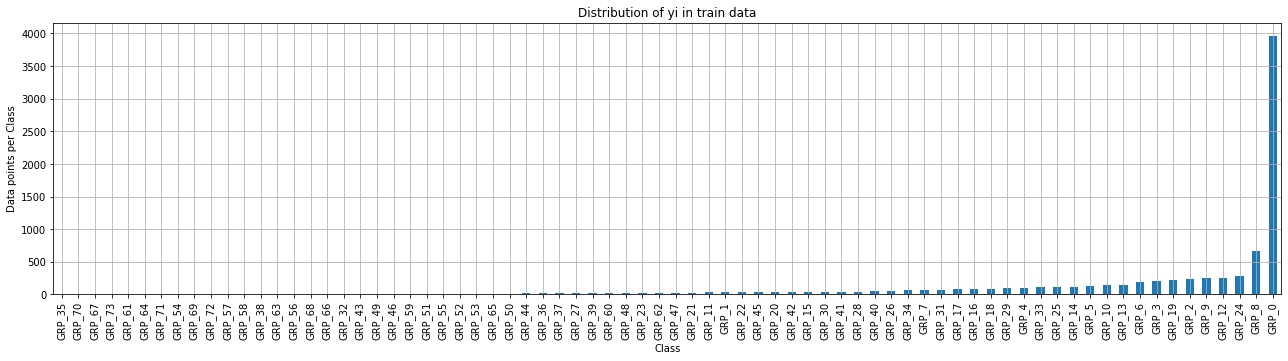

In [15]:
target_dist = data['Assignment group'].value_counts().sort_values()

my_colors = 'rgbkymc'
plt.subplots(figsize=(22,5))
target_dist.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

1. Distribution of target class is skewed.
2. Some groups have less than 10 tickets assigned to them.
3. We can form a single group combining such groups.
4. This will help us to reduce imbalance to some extent.

In [17]:
# Creating a single group of groups having less than 10 tickets assigned.
sample = data.groupby(['Assignment group'])
regroup=[]
for grp in data['Assignment group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
data['Assignment group']=data['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
data['Assignment group'].unique()

Found 0 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

In [18]:
len(data['Assignment group'].unique())

50

 1. Now there are 50 unique groups

### Remove caller feature

In [ ]:
#data = data.drop("Caller", axis=1)
#data = data.drop("Short description", axis=1)


### Merge Short Description and Description

In [19]:
data['Description'] = data['Description'].str.cat(data['Short description'], sep =" ")

In [20]:
data = data.drop("Short description", axis=1)

### Data preprocessing

#### Translation of German description to english

In [21]:
germanwordlist = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwordlist)

pattern

'bitte|nicht|konto|probleme|berechtigung|defekt|mehr|ausgetauscht|rechner|drucker|teilweise|freigegeben|genannten|anmeldeaccount|besprochen|werden|durchwahl|oben|einrichten|zeitwirtschaft|seit|morgens|beheben|keine|zeitbuchungen|vorhanden|dringend|fehler|werk|anmelde|auftrag|kein|skannen|freundlichen|werkzeuge,|hartstoffe|maste|schutzw|fertigung|immer|sehr|zugriff|freundliche|geehrter|souzarft|noch|verbindungsherstellung|meldung|erneuten|glich|proben|beilageproben|beilage|auswerten|sinterleitstand|reparar|reparo|rechner|koenigsee|entregar|atualiza|declara|programdntya|funcionando|preciso|hitacni|grergtger|zugriffsrechte|teamleiter|abholen|wegen|weit|absender|wenn|abrechnung'

#### Index positions having description in german

In [22]:
germanDescIndex = data[data['Description'].str.contains(pattern)].index
germanDescIndex

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8498, 8499],
           dtype='int64', length=613)

In [23]:
# Before translation in english
data['Description'][223]

'hallo ,\n\nes ist erneut passiert. der pc hat sich zum wiederholten male aufgehÃ¤ngt und mir lediglich einen blauen bildschirm mit weisser schrift prÃ¤sentiert.\n\nwas kÃ¶nnen wir da machen?\n\n probleme mit bluescreen .'

In [24]:
# translation from german to english.
!pip install googletrans==3.1.0a0
from googletrans import Translator

def translateIfRequired(x):
    translator = Translator()
    if translator.detect(x).lang != 'en':
        translatedText = translator.translate(x).text
    else:
        translatedText = x
    return translatedText

     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 1.0MB 27.1MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=c56f511eb91f39b3467764394b36f241ef2ee10ae6bc3b9e547c694922185454
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [25]:
for rowId in germanDescIndex:
    data['Description'][rowId] = translateIfRequired(data['Description'][rowId])

In [26]:
#After translation in english
data['Description'][223] 

'Hello ,\n\nit happened again. the pc hung itself up again and again and only presented me with a blue screen with white letters.\n\nwhat can we do there?\n\n problems with bluescreen.'

In [27]:
# Store the translated file
file = open('/content/data_translated', 'wb')
pickle.dump(data, file)

In [69]:
file = open('/content/data_translated', 'rb')
data = pickle.load(file)

In [70]:
data.head(10)

,Description,Caller,Assignment group
0,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page unable to access...,xbkucsvz gcpydteq,GRP_0
4,skype error skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype...,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook unable to...,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773 ticket update ...,fumkcsji sarmtlhy,GRP_0


#### Remove stopwords

In [71]:
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))

def text_preprocessing(total_text, index, column):
  if type(total_text) is not int:
        string = ""
        #total_text = re.sub(r"\d{2}[-|/]\d{2}[-|/]\d{4}", ' ', total_text)
        #total_text = re.sub(r"\d{2}:\d{2}:\d{2}", ' ', total_text)
        #total_text = re.sub(r"\d{2}:\d{2}", ' ', total_text)
        # replace every special char with space
       
        total_text = re.sub(r"^[a-zA-Z0-9+_.-]+@[a-zA-Z0-9.-]+$", ' ', total_text)
        total_text = re.sub(r"received from:", ' ', total_text)
        total_text = re.sub(r"from:", ' ', total_text)
        total_text = re.sub(r"to:", ' ', total_text)
        total_text = re.sub(r"subject:", ' ', total_text)
        total_text = re.sub(r"sent:", ' ', total_text)
        total_text = re.sub(r"ic:", ' ', total_text)
        total_text = re.sub(r"cc:", ' ', total_text)
        total_text = re.sub(r"bcc:", ' ', total_text)
        total_text = re.sub(r".com", ' ', total_text)
        total_text = re.sub('[^a-zA-Z\n]', ' ', total_text)
        total_text = re.sub('hi', ' ', total_text)
        total_text = re.sub('hello', ' ', total_text)
        
        #total_text = re.sub(r"\Aat:", ' ', total_text)

        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data[column][index] = string
  

    

In [72]:
for index, row in data.iterrows():
    #if type(row['Description']) is str:
    text_preprocessing(row['Description'], index, 'Description')
    #else:
    #print("there is no text description for id:",index)

In [73]:
data['Description'][90]

'monitoring tool pany job sid cold failed job scheduler job sid cold failed job scheduler '

#### Remove duplicate rows

In [75]:
data = data.drop_duplicates("Description",keep='first')

In [76]:
data.shape

(6700, 3)

In [77]:
len(data['Assignment group'].unique())

50

#### Lemmatization

In [78]:
lemmatizer = WordNetLemmatizer()
def lematize(sentence):
  a = []
  tokens = nltk.word_tokenize(sentence)
  for word in tokens:
    #print (word)
    s = lemmatizer.lemmatize(word)
    #print(s)
    a.append(s)
    a.append(" ")
  new_sent = " ".join(a)
  return new_sent
  #print(new_sent)
  #data[column][index] = new_sent

In [79]:
data['Description'] = data['Description'].apply(lematize)

In [80]:
data['Description'][2]

'eylqgodm   ybqkwiam   gmail   can   not   log   vpn   best   cant   log   vpn  '

#### Remov callers name from Description.

Most of the descriptions contains the callers name. We can remove that from description as it wont add much value.

In [81]:
# get all the callers from column Caller
callers = data['Caller'].values

In [82]:
# Split first name, last name and add them in one list
l = []
for i in callers:
  l.append(i.split()[0])
  l.append(i.split()[1])

In [83]:
# For each description check if the word is present in list l. Join the words that are not present in list l.
data['Description'] = data['Description'].apply(lambda x : " ".join([word for word in x.split() if word not in l]))

In [84]:
# After removing callers name.
data['Description'][2]

'gmail can not log vpn best cant log vpn'

#### Remove duplicate words from Description

As we have joined the short description and description, there are some duplicate words which should be removed.

In [85]:
# Below function remove duplicate words from string
# reference - https://www.geeksforgeeks.org/python-remove-duplicates-words-given-sentence/

from collections import Counter
  
def remov_duplicates(input):
  
    # split input string separated by space
    input = input.split(" ")
  
    # joins two adjacent elements in iterable way
    for i in range(0, len(input)):
        input[i] = "".join(input[i])
  
    # now create dictionary using counter method
    # which will have strings as key and their 
    # frequencies as value
    UniqW = Counter(input)
  
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    return s

In [86]:
data['Description'] = data['Description'].apply(remov_duplicates)

#### Word Cloud

In [87]:
# Get all descriptions for tickets assigned to GRP_0
grp_0 = data.loc[data['Assignment group'] == 'GRP_0']['Description']

In [89]:
# Convert them in one string
des_str = " "
for sent in grp_0.values:
   des_str = des_str + " " + sent

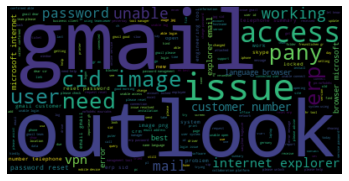

In [91]:
# Code to generate word cloud for GRP_0

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(des_str)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
# Get all descriptions for tickets assigned to groups other than GRP_0

other = data.loc[data['Assignment group'] != 'GRP_0']['Description']

In [93]:
# Convert them in one string

des_str_other = " "
for sent in other.values:
   des_str_other = des_str_other + " " + sent

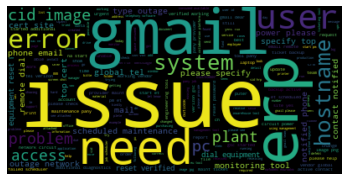

In [94]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(des_str_other)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

1. From first word cloud it seems outlook and access related issues are assigned to GRP_0
2. From second  word cloud it seems erp  related issues are not assigned to GRP_0

### Store prerocessed data

In [95]:
file = open('/content/data_clean', 'wb')
pickle.dump(data, file)

### Model 1 - GRP0 Vs Others

In [96]:
file = open('/content/data_clean', 'rb')
data_clean = pickle.load(file)

#### Data distribution

In [97]:
data_clean['Assignment group'] = data_clean['Assignment group'].apply(lambda x : 'others' if x != 'GRP_0' else x)

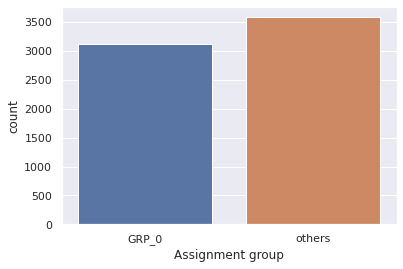

In [98]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data=data_clean)

#### Split data in training and testing data

In [99]:
X = data_clean['Description']
Y = data_clean['Assignment group']

In [100]:
Y = Y.map({'GRP_0': 0, 'others':1})

In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.25, stratify=Y, shuffle=True)

In [103]:
X_train.shape

(5025,)

In [104]:
X_test.shape

(1675,)

#### Vectorization

##### TFIDF

In [105]:
vectorizer = TfidfVectorizer(
    analyzer="word", max_df=0.3, min_df=10, ngram_range=(1, 2), norm="l2"
)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.3, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [106]:
x_train_tfidf = vectorizer.transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

In [107]:
x_train_tfidf.shape

(5025, 1883)

In [108]:
x_test_tfidf.shape

(1675, 1883)

#### Modeling

In [118]:
classifiers = [
    LogisticRegression(solver="sag", random_state=1),
    LinearSVC(random_state=1),
    RandomForestClassifier(random_state=1),
    XGBClassifier(random_state=1),
    MLPClassifier(
        random_state=1,
        solver="adam",
        hidden_layer_sizes=(12, 12, 12),
        activation="relu",
        early_stopping=True,
        n_iter_no_change=1,
    ),
]

In [119]:
names =  ['LogisticRegression', 'LinearSVC', 'RandomForestClassifier', 'XGBClassifier', 'MLPClassifier']

In [120]:
%%time
# test all classifiers and save pred. results on test data
results = {}
for name, clf in zip(names, classifiers):
    print(f"Training classifier: {name}")
    clf.fit(x_train_tfidf, Y_train)
    prediction = clf.predict(x_test_tfidf)
    report = sklearn.metrics.classification_report(Y_test, prediction)
    #conf_mat = confusion_matrix(Y_test, prediction)
    results[name] = report

Training classifier: LogisticRegression
Training classifier: LinearSVC
Training classifier: RandomForestClassifier
Training classifier: XGBClassifier
Training classifier: MLPClassifier
CPU times: user 5.3 s, sys: 514 ms, total: 5.81 s
Wall time: 5.28 s


In [121]:
# Prediction results
for k, v in results.items():
    print(f"Results for {k}:")
    print(f"{v}\n")


Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       781
           1       0.82      0.82      0.82       894

    accuracy                           0.81      1675
   macro avg       0.81      0.81      0.81      1675
weighted avg       0.81      0.81      0.81      1675


Results for LinearSVC:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       781
           1       0.81      0.80      0.80       894

    accuracy                           0.79      1675
   macro avg       0.79      0.79      0.79      1675
weighted avg       0.79      0.79      0.79      1675


Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       781
           1       0.81      0.82      0.82       894

    accuracy                           0.80      1675
   macro avg       0.80      0.80  

In [123]:
# feature creation and modelling in a single function
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("log_reg", LogisticRegression(class_weight='balanced'))])

# define parameter space to test # runtime 35min
params = {
    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8, 0.2),
    "tfidf__min_df": np.arange(5, 100, 45),
}
pipe_clf = GridSearchCV(pipe, params, n_jobs=-1, scoring="f1_macro")
pipe_clf.fit(X_train, Y_train)
#pickle.dump(pipe_clf, open("./clf_pipe.pck", "wb"))

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [124]:
print(pipe_clf.best_params_)

{'tfidf__max_df': 0.3, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [125]:
%%time
# feature creation and modelling in a single function
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("logreg", LogisticRegression(class_weight='balanced'))])

# define parameter space to test # runtime 19min
params = {
    "tfidf__ngram_range": [(1, 2)],
    "tfidf__max_df": [0.3],
    "tfidf__min_df": [5],
    "logreg__C": [0.001, 0.1, 1, 10]
}
pipe_logreg_clf = GridSearchCV(pipe, params, n_jobs=-1, scoring="f1_macro")
pipe_logreg_clf.fit(X_train, Y_train)
#pickle.dump(pipe_logreg_clf, open("/content/Model1.pkl", "wb"))

CPU times: user 615 ms, sys: 28.2 ms, total: 643 ms
Wall time: 6.24 s


In [126]:
best_params = pipe_logreg_clf.best_params_
print(best_params)

{'logreg__C': 1, 'tfidf__max_df': 0.3, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [127]:
# run pipe with optimized parameters
pipe.set_params(**best_params).fit(X_train, Y_train)
pipe_pred = pipe.predict(X_test)
report = sklearn.metrics.classification_report(Y_test, pipe_pred)
conf_mat = confusion_matrix(Y_test, pipe_pred)
print(report)
#print(conf_mat)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       781
           1       0.84      0.80      0.82       894

    accuracy                           0.82      1675
   macro avg       0.82      0.82      0.82      1675
weighted avg       0.82      0.82      0.82      1675

[[649 132]
 [177 717]]


#### Store the model 

In [129]:
pickle.dump(pipe, open("/content/Model1.pkl", "wb"))